In [1]:
from itertools import groupby
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
from tqdm import tqdm
from scipy.stats import ttest_ind
import os
%matplotlib inline

import numpy as np

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
n_trials = 200
n_toremove = 2
alpha = 0.05
df = pd.read_csv(os.path.join('data', 'stats', 'raw_data.csv'))
rho_dict = {'loudness': 0.320317,
            'roughness': 0.346654,
            'model_unp': 0.505430,
            'loud_diff': -0.253201,
            'pow_diff': -0.383311,
            'model_det': 0.491681}


title_p1 = 'Expected value of '
title_p2 = ' as a surrogate model for '
titles = {'loudness': title_p1 + 'Loudness' + title_p2 + 'Unpleasantness',
          'roughness': title_p1 + 'Roughness' + title_p2 + 'Unpleasantness',
          'model_unp': title_p1 + 'the Subject Model' + title_p2 + 'Unpleasantness',
          'loud_diff': title_p1 + 'Loudness difference' + title_p2 + 'Detectability',
          'pow_diff': title_p1 + 'Power difference' + title_p2 + 'Detectability',
          'model_det': title_p1 + 'the Subject Model' + title_p2 + 'Detectability'}
labels = {'loudness': 'Loudness [sone]',
          'roughness': 'Roughness [asper]',
          'model_unp': 'Unpleasantness [arb. unit]',
          'loud_diff': 'Loudness difference [sone]',
          'pow_diff': 'Power diffrence [W]',
          'model_det': 'Detectio time [s]'}

In [3]:
def plot_CI(n_trials, n_toremove, x_str, df, alpha, rho_dict, titles, labels, correct=False):
    n_modalities = 4
    n_variables = 6
    
    if correct:
        corr = n_variables
    else:
        corr = 1    

    fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True)
    significant = []
    brackloc = []
    prob = []
    false_mat = []
    
    
    
    sigma_X = np.std(df[x_str.split('-')[0]])
    sigma_B = sigma_X * np.sqrt(1 / rho_dict[x_str]**2 - 1)
    B_mat = np.random.randn(len(df), n_trials) * sigma_B
        
    for variable in range(1, 1+n_variables):
        row = (variable - 1) // 3
        col = (variable - 1) % 3

        VX = sorted(zip(df["x{}".format(variable)], df[x_str.split('-')[0]]))
        VX = [[pair[1] for pair in Xv] for (v, Xv) in groupby(VX, key=itemgetter(0))]
        musx = np.array([np.mean(vx) for vx in VX])
        order = np.argsort(musx)
        
        mus = []
        
        for trial_id in range(n_trials):
            B = B_mat[:, trial_id]
            Y = df[x_str.split('-')[0]] + B
            VY = sorted(zip(np.array(df["x{}".format(variable)]), Y))
            VY = [[pair[1] for pair in Yv] for (v, Yv) in groupby(VY, key=itemgetter(0))]
            mus.append(np.array([np.mean(vy) for vy in VY]))
        mus = np.stack(mus)

        mus = mus[:, order]
    
        
        false_vec = np.zeros(mus.shape[0], dtype=bool)
        
        for rem_idx in range(n_toremove):
            temp_false_vec = np.any(np.less(mus[:, [4 - rem_idx - 1]], mus[:, :(4 - n_toremove)]), axis=1)
            false_vec = np.logical_or(false_vec, temp_false_vec)
            
            
        n_false = np.sum(false_vec, axis=0)
        prob_var = n_false / n_trials
        prob.append(prob_var)
        quantiles = np.quantile(mus, [alpha / 2, 1 - alpha / 2], axis=0)
        
        brackloc.append(quantiles[1, 3])

        for i in range(len(VX)):
            x = i + np.random.rand(mus.shape[0]) * 0.08 - 0.04
            axes[row, col].scatter(x, mus[:, i],
                                  marker='.',
                                  s=0.2,
                                  alpha=0.8)
        
        axes[row, col].scatter(np.arange(musx.shape[0]), musx[order],
                               c='k',
                               marker='.')

        axes[row, col].set_xticks([])
        
        if col == 0:
            axes[row, col].set_ylabel(labels[x_str])
        axes[row, col].grid(linestyle='--')

        axes[row, col].set_title('Variable {}'.format(variable))
    
    

    ylimits = axes[row, col].get_ylim()
    xlimits = axes[row, col].get_xlim()

    for idx in range(n_variables):
        row = idx // 3
        col = idx % 3

        axes[row, col].plot(2 * [4 - n_toremove - 0.5], 
                     ylimits, 
                     linestyle='dotted', 
                     color='k',
                     linewidth=0.7)

        axes[row, col].plot([-0.25, 3.25],
                     2 * [brackloc[idx] + 0.03 * (ylimits[1] - ylimits[0])], 
                     marker=3,
                     color='k',
                     markersize=6)
        
        if prob[idx] < 0.01:
            perc_text = '<1%'
        else:
            perc_text = ("%.0f" % (prob[idx] * 100)) + '%'
            
        axes[row, col].text(4 - n_toremove - 0.5, 
                     brackloc[idx] + 0.07 * (ylimits[1] - ylimits[0]),
                     perc_text,
                     ha='center',
                     va='center')
        axes[row, col].text((4 - n_toremove - 0.5 + xlimits[0]) / 2,
                     ylimits[0],
                     'keep',
                     ha='center',
                     va='center')
        axes[row, col].text((4 - n_toremove - 0.5 + xlimits[1]) / 2,
                     ylimits[0],
                     'discard',
                     ha='center',
                     va='center')
    
    plt.suptitle(titles[x_str], y=1, va='top', fontproperties={'weight': 'bold',
                                            'size': 'x-large'})
    filename = 'confidence-intervals-' + x_str + 'keep' + str(4 - n_toremove)
    plt.savefig(os.path.join('figures', 'stat_hyp_test', filename + '.pdf'))
    plt.savefig(os.path.join('figures', 'stat_hyp_test', filename + '.png'))
    
    return significant, prob

In [4]:
x_str_list = [*rho_dict]

100%|██████████| 6/6 [03:23<00:00, 33.97s/it]


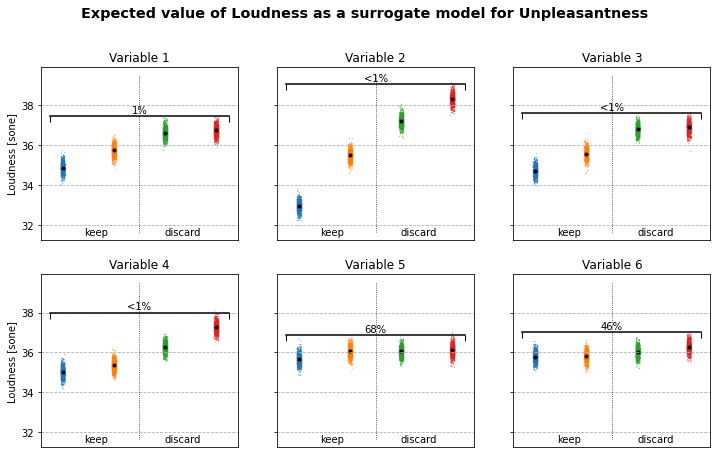

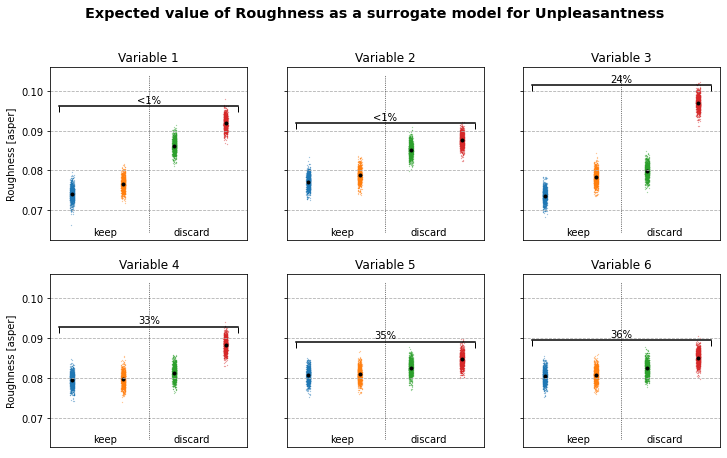

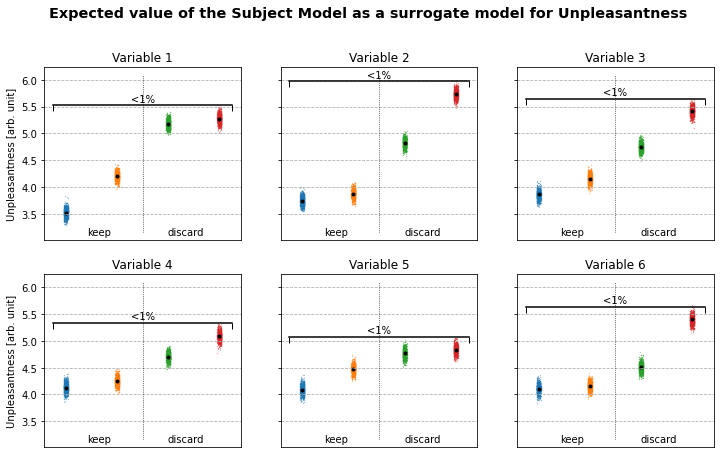

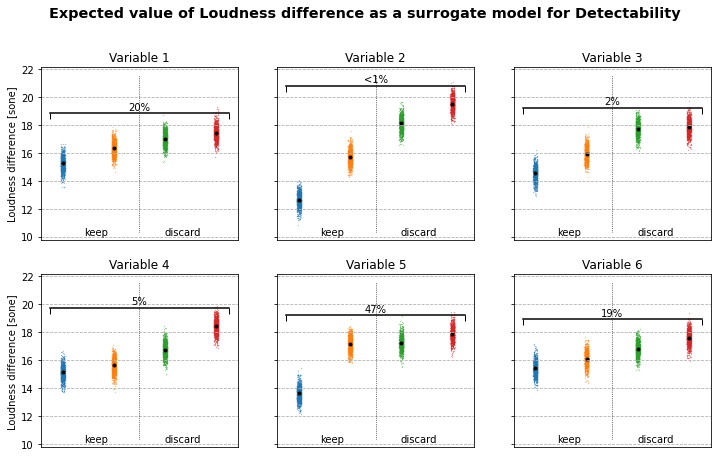

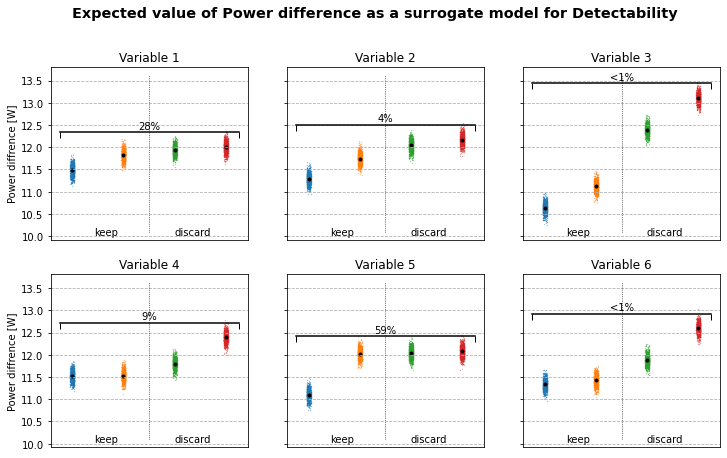

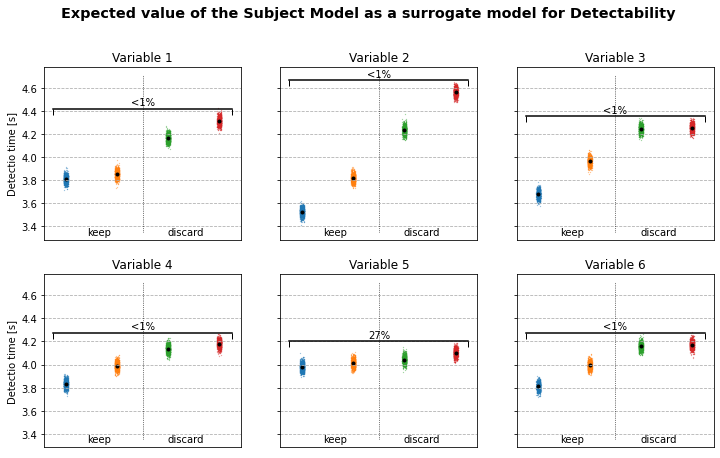

In [5]:
n_trials = 1000
n_toremove = 2
significant_list = []
prob_list = []
false_mat_list = []
for x_str in tqdm(x_str_list):
    significant, prob = plot_CI(n_trials, n_toremove, x_str, df, alpha, rho_dict, titles, labels, correct=True)
    significant_list.append(significant)
    prob_list.append(prob)

In [6]:
df_stats = pd.DataFrame.from_dict({x_str: prob for x_str, prob in zip(x_str_list, prob_list)}, 
                                  orient='index', 
                                  columns=['p' + str(idx + 1) for idx in range(6)])

In [7]:
df_stats

,p1,p2,p3,p4,p5,p6
loudness,0.01,0.00,0.00,0.01,0.69,0.46
roughness,0.00,0.01,0.24,0.33,0.35,0.36
model_unp,0.00,0.00,0.00,0.00,0.00,0.00
loud_diff,0.20,0.00,0.02,0.05,0.47,0.19
pow_diff,0.28,0.04,0.00,0.09,0.59,0.00
model_det,0.00,0.00,0.00,0.00,0.27,0.00
